In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
!pip install torch torchvision torchaudio --quiet
!pip install matplotlib numpy scikit-learn tqdm kagglehub --quiet

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import kagglehub

In [ ]:
# Download dataset via kagglehub
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Kaggle dataset root path:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Kaggle dataset root path: /kaggle/input/chest-xray-pneumonia


In [ ]:
# In this dataset, images live under: <path>/chest_xray/train, /val, /test
data_dir = os.path.join(path, "chest_xray")
print("Using data_dir:", data_dir)

Using data_dir: /kaggle/input/chest-xray-pneumonia/chest_xray


In [ ]:
#Verify folder structure (top level)
for root, dirs, files in os.walk(data_dir):
    print("Subfolders inside data_dir:", dirs)
    break

# Simple transform for preview
preview_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load training set
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"),
                                     transform=preview_transform)
print("Classes:", train_dataset.classes)

Subfolders inside data_dir: ['chest_xray', '__MACOSX', 'val', 'test', 'train']
Classes: ['NORMAL', 'PNEUMONIA']


Normal indices: [0, 1]
Pneumonia indices: [1341, 1342]


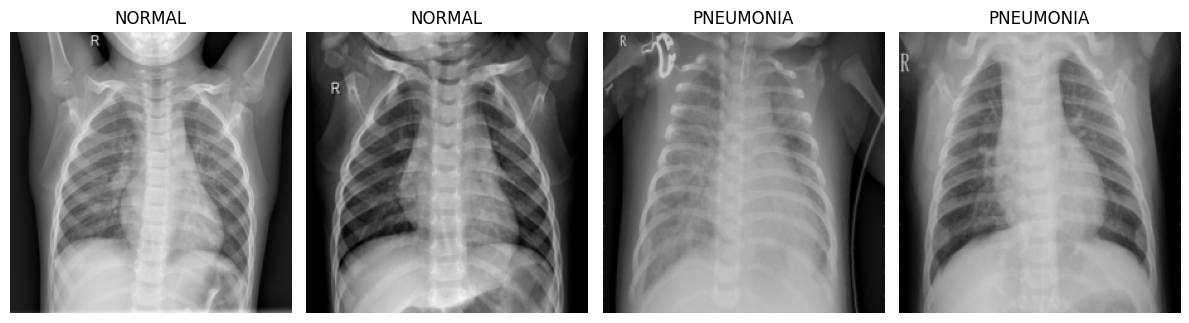

In [ ]:
import matplotlib.pyplot as plt
import torch


normal_indices = []
pneumonia_indices = []

for idx, (_, label) in enumerate(train_dataset):
    if label == 0 and len(normal_indices) < 2:      # 0 -> NORMAL
        normal_indices.append(idx)
    if label == 1 and len(pneumonia_indices) < 2:   # 1 -> PNEUMONIA
        pneumonia_indices.append(idx)
    if len(normal_indices) == 2 and len(pneumonia_indices) == 2:
        break

print("Normal indices:", normal_indices)
print("Pneumonia indices:", pneumonia_indices)


indices_to_show = normal_indices + pneumonia_indices

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for ax, idx in zip(axes, indices_to_show):
    img, label = train_dataset[idx]
    # undo normalization if you used it (optional)
    if img.shape[0] == 3:
        img_disp = img.permute(1, 2, 0)
    else:
        img_disp = img.squeeze(0)
    ax.imshow(img_disp, cmap="gray")
    ax.set_title(train_dataset.classes[label])
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

print("Using data_dir:", data_dir)

# Choose device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---- Transforms ----
# For training: small realistic augmentations + normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# For validation / test: no augmentation, only resize + normalize
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ---- Datasets ----
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"),
                                     transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, "val"),
                                     transform=val_test_transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, "test"),
                                     transform=val_test_transform)

# ---- DataLoaders ----
batch_size = 32
num_workers = 2 if torch.cuda.is_available() else 0

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=num_workers)

print("Number of train images:", len(train_dataset))
print("Number of val images:  ", len(val_dataset))
print("Number of test images: ", len(test_dataset))
print("Classes:", train_dataset.classes)


Using data_dir: /kaggle/input/chest-xray-pneumonia/chest_xray
Using device: cuda
Number of train images: 5216
Number of val images:   16
Number of test images:  624
Classes: ['NORMAL', 'PNEUMONIA']


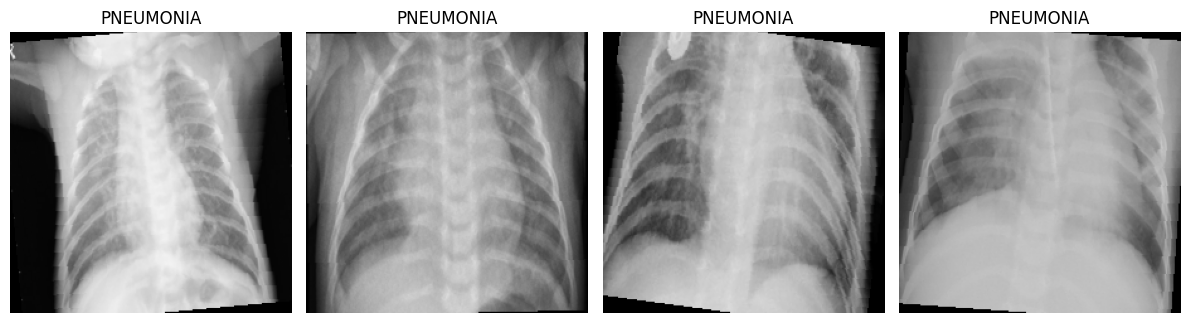

In [ ]:
# augmented training images (good for PPT slide)
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    img = images[i].clone()

    # un-normalize for display
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + \
          torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.clamp(0, 1)

    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(train_dataset.classes[labels[i]])
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter

def count_per_class(dataset, name):
    labels = [label for _, label in dataset]
    counts = Counter(labels)
    print(f"\n{name} set:")
    for idx, cls_name in enumerate(dataset.classes):
        print(f"  {cls_name}: {counts[idx]}")

count_per_class(train_dataset, "Train")
count_per_class(val_dataset,   "Val")
count_per_class(test_dataset,  "Test")



Train set:
  NORMAL: 1341
  PNEUMONIA: 3875

Val set:
  NORMAL: 8
  PNEUMONIA: 8

Test set:
  NORMAL: 234
  PNEUMONIA: 390


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

print("Device:", device)
print("Train batches:", len(train_loader), "| Val batches:", len(val_loader))


Device: cuda
Train batches: 163 | Val batches: 1


In [ ]:
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in resnet.parameters():
    param.requires_grad = False

for param in resnet.layer4.parameters():
    param.requires_grad = True

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {"params": resnet.layer4.parameters(), "lr": 1e-5},
    {"params": resnet.fc.parameters(),      "lr": 1e-4},
])


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


In [ ]:
def train_resnet(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0.0
    best_weights = None

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        model.train()
        running_corrects = 0
        running_total = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()
            running_total += labels.size(0)

        epoch_train_acc = running_corrects / running_total
        train_acc_history.append(epoch_train_acc)

        model.eval()
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_acc = val_corrects / val_total
        val_acc_history.append(epoch_val_acc)

        print(f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_weights = model.state_dict()

    print(f"\nBest validation accuracy: {best_val_acc:.4f}")
    if best_weights is not None:
        torch.save(best_weights, "resnet_best.pth")
        print("Best ResNet weights saved to resnet_best.pth")

    plt.figure(figsize=(6,4))
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("ResNet-50 Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, train_acc_history, val_acc_history



Epoch 1/5
------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Acc: 0.9827 | Val Acc: 0.8750

Epoch 2/5
------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Acc: 0.9850 | Val Acc: 0.8125

Epoch 3/5
------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Acc: 0.9877 | Val Acc: 0.7500

Epoch 4/5
------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2b65709da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2b65709da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
if w.is_alive():    
 self._shutdown_workers()  
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
        ^ ^ ^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

Training:   0%|          | 0/163 [00:01<?, ?it/s]

              ^ ^^ ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^AssertionError^: ^can only test a child process^
^^Traceback (most recent call last):
^  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
^  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
^  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
^OSError: [Errno 9] Bad file descriptor

AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Acc: 0.9887 | Val Acc: 0.7500

Epoch 5/5
------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Acc: 0.9898 | Val Acc: 0.8125

Best validation accuracy: 0.8750


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 291, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 25

Best ResNet weights saved to resnet_best.pth


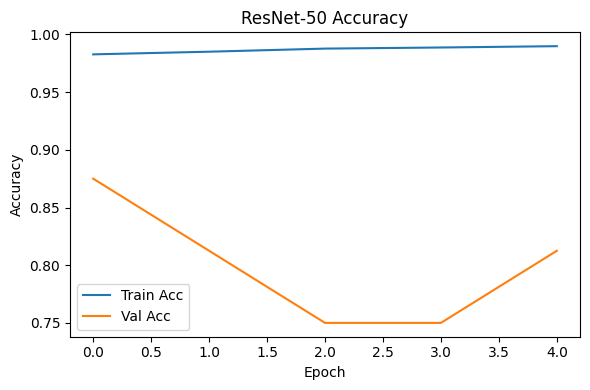

In [ ]:
resnet, resnet_train_acc, resnet_val_acc = train_resnet(
    resnet, train_loader, val_loader, criterion, optimizer, num_epochs=5
)


=== ResNet-50 Test Performance ===
              precision    recall  f1-score   support

      NORMAL       0.97      0.48      0.64       234
   PNEUMONIA       0.76      0.99      0.86       390

    accuracy                           0.80       624
   macro avg       0.87      0.74      0.75       624
weighted avg       0.84      0.80      0.78       624



<Figure size 400x400 with 0 Axes>

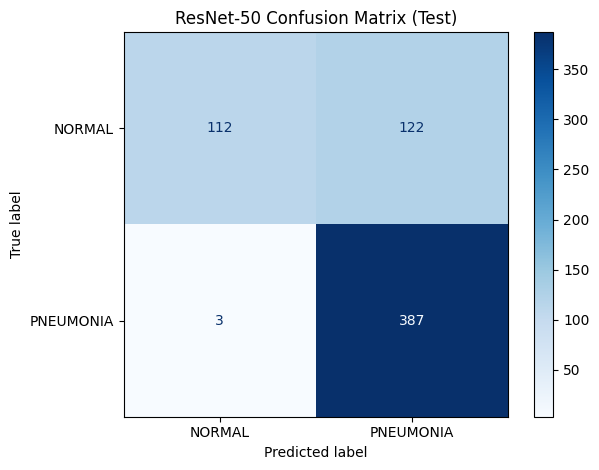

In [ ]:
#Evaluate ResNet on Test Set
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import torch

# Load best saved weights (just to be sure)
resnet.load_state_dict(torch.load("resnet_best.pth", map_location=device))
resnet.eval()

all_labels = []
all_preds  = []

# Go through test set
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)

# Classification report (Accuracy, Precision, Recall, F1)
print("=== ResNet-50 Test Performance ===")
print(classification_report(all_labels, all_preds,
                            target_names=train_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=train_dataset.classes)

plt.figure(figsize=(4,4))
disp.plot(cmap="Blues", values_format="d")
plt.title("ResNet-50 Confusion Matrix (Test)")
plt.tight_layout()
plt.show()


In [ ]:
#Step 5 - Define & Train Vision Transformer (ViT-B/16)
import torch
import torch.nn as nn
from torchvision import models
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

print("Device:", device)

Device: cuda


In [ ]:
# ----Build ViT model ----
vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# Freeze all parameters first
for param in vit.parameters():
    param.requires_grad = False

# Unfreeze last encoder block (optional fine-tuning)
for param in vit.encoder.layers[-1].parameters():
    param.requires_grad = True

# Replace classification head for 2 classes
num_ftrs_vit = vit.heads.head.in_features
vit.heads.head = nn.Linear(num_ftrs_vit, 2)

vit = vit.to(device)

criterion_vit = nn.CrossEntropyLoss()

optimizer_vit = torch.optim.Adam([
    {"params": vit.encoder.layers[-1].parameters(), "lr": 1e-5},
    {"params": vit.heads.head.parameters(),         "lr": 1e-4},
])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 185MB/s]


In [ ]:
# ---- Generic training function for ViT ----
def train_vit(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0.0
    best_weights = None

    for epoch in range(num_epochs):
        print(f"\n[ViT] Epoch {epoch+1}/{num_epochs}")
        print("-" * 35)

        # TRAIN
        model.train()
        running_corrects = 0
        running_total = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()
            running_total += labels.size(0)

        epoch_train_acc = running_corrects / running_total
        train_acc_history.append(epoch_train_acc)

        # VALIDATION
        model.eval()
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_acc = val_corrects / val_total
        val_acc_history.append(epoch_val_acc)

        print(f"ViT Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_weights = model.state_dict()

    print(f"\nBest ViT validation accuracy: {best_val_acc:.4f}")
    if best_weights is not None:
        torch.save(best_weights, "vit_best.pth")
        print("Best ViT weights saved to vit_best.pth")

    # Plot accuracy curves (for PPT)
    plt.figure(figsize=(6,4))
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("ViT-B/16 Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, train_acc_history, val_acc_history



[ViT] Epoch 1/5
-----------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ViT Train Acc: 0.8790 | Val Acc: 0.7500


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 291, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times



[ViT] Epoch 2/5
-----------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2b65709da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ViT Train Acc: 0.9494 | Val Acc: 0.7500

[ViT] Epoch 3/5
-----------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2b65709da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


Training:   0%|          | 0/163 [00:01<?, ?it/s]

    assert self._parent_pid == os.getpid(), 'can only test a child process'
  Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2b65709da0> 
 Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
 ^    ^if w.is_alive():^
^ ^ ^ ^^ ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^
AssertionError  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
: can only test a child process
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 Traceback (most recent call last):
   File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
   File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
   File "/usr/lib/python3.12/multiproces

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ViT Train Acc: 0.9626 | Val Acc: 0.7500

[ViT] Epoch 4/5
-----------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2b65709da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
        Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
 

Training:   0%|          | 0/163 [00:00<?, ?it/s]

  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 291, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times
Exception ignored in: <function _MultiProcessingDataLoade

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2b65709da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2b65709da0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    if w.is_alive():    self._shutdown_workers()

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
  ^ ^ ^ ^ ^  ^ ^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^ ^ 
  File "/usr/lib/pyt

ViT Train Acc: 0.9668 | Val Acc: 0.7500

[ViT] Epoch 5/5
-----------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ViT Train Acc: 0.9712 | Val Acc: 0.7500

Best ViT validation accuracy: 0.7500


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 291, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


Best ViT weights saved to vit_best.pth


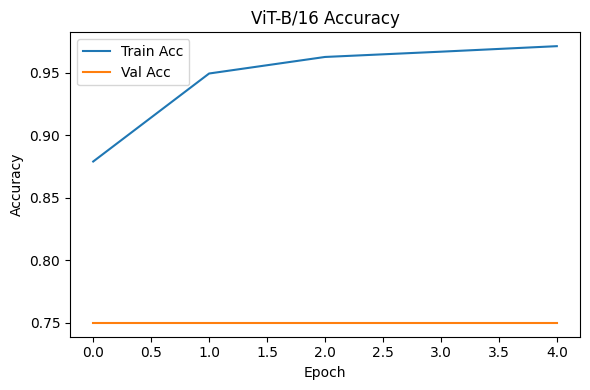

In [ ]:
# ----Run training ----
vit, vit_train_acc, vit_val_acc = train_vit(
    vit, train_loader, val_loader, criterion_vit, optimizer_vit, num_epochs=5
)

=== ViT-B/16 Test Performance ===
              precision    recall  f1-score   support

      NORMAL       0.98      0.51      0.67       234
   PNEUMONIA       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.75      0.77       624
weighted avg       0.85      0.81      0.80       624



<Figure size 400x400 with 0 Axes>

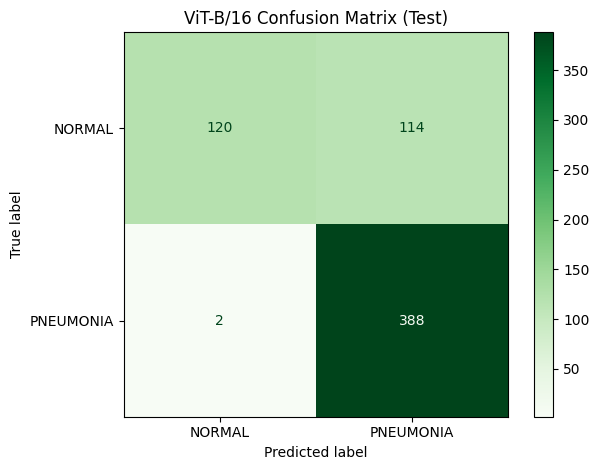

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import torch

# Load best ViT weights and set to eval
vit.load_state_dict(torch.load("vit_best.pth", map_location=device))
vit.eval()

all_labels_vit = []
all_preds_vit  = []

# Loop over test set
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = vit(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels_vit.extend(labels.cpu().numpy())
        all_preds_vit.extend(preds.cpu().numpy())

all_labels_vit = np.array(all_labels_vit)
all_preds_vit  = np.array(all_preds_vit)

# Classification report
print("=== ViT-B/16 Test Performance ===")
print(classification_report(all_labels_vit, all_preds_vit,
                            target_names=train_dataset.classes))

# Confusion matrix
cm_vit = confusion_matrix(all_labels_vit, all_preds_vit)
disp_vit = ConfusionMatrixDisplay(confusion_matrix=cm_vit,
                                  display_labels=train_dataset.classes)

plt.figure(figsize=(4,4))
disp_vit.plot(cmap="Greens", values_format="d")
plt.title("ViT-B/16 Confusion Matrix (Test)")
plt.tight_layout()
plt.show()


True label: NORMAL
Predicted label: PNEUMONIA


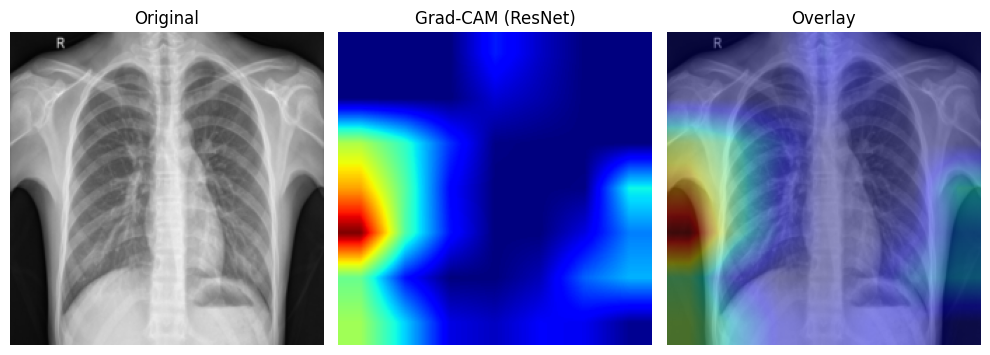

In [ ]:
#Grad-CAM for ResNet (CNN)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

resnet.load_state_dict(torch.load("resnet_best.pth", map_location=device))
resnet.eval()

feature_maps = None
gradients = None

def forward_hook(module, input, output):
    global feature_maps
    feature_maps = output

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

handle_fwd = resnet.layer4[-1].register_forward_hook(forward_hook)
handle_bwd = resnet.layer4[-1].register_full_backward_hook(backward_hook)

# pick an image index from test_dataset (change idx to see different ones)
idx = 12
img_tensor, label = test_dataset[idx]
input_batch = img_tensor.unsqueeze(0).to(device)
print("True label:", train_dataset.classes[label])

# forward + backward
output = resnet(input_batch)
pred_class = output.argmax(dim=1).item()
print("Predicted label:", train_dataset.classes[pred_class])

resnet.zero_grad()
one_hot = torch.zeros_like(output)
one_hot[0, pred_class] = 1
output.backward(gradient=one_hot)

grads = gradients[0]
acts  = feature_maps[0]
weights = grads.mean(dim=(1, 2))
cam = torch.zeros(acts.shape[1:], dtype=torch.float32).to(device)
for w, a in zip(weights, acts):
    cam += w * a
cam = F.relu(cam)
cam = (cam - cam.min()) / (cam.max() + 1e-8)
cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0),
                    size=(224, 224), mode="bilinear", align_corners=False)
cam = cam.squeeze().detach().cpu().numpy()

# de-normalize image
img = img_tensor.clone()
img = img * torch.tensor([0.229,0.224,0.225]).view(3,1,1) + \
      torch.tensor([0.485,0.456,0.406]).view(3,1,1)
img = img.clamp(0,1).permute(1,2,0).cpu().numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(cam, cmap="jet"); plt.title("Grad-CAM (ResNet)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(img); plt.imshow(cam, cmap="jet", alpha=0.4)
plt.title("Overlay"); plt.axis("off")
plt.tight_layout(); plt.show()

handle_fwd.remove(); handle_bwd.remove()


True label: NORMAL
Predicted label (ViT): NORMAL


sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
/tmp/ipython-input-2610318521.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vit_cam = torch.tensor(vit_cam).unsqueeze(0).unsqueeze(0)


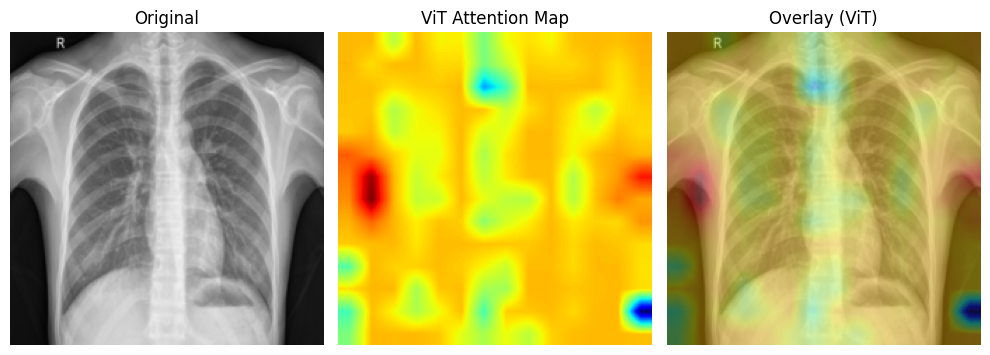

In [ ]:
#ViT Attention-style Heatmap (Same image)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# load best ViT weights
vit.load_state_dict(torch.load("vit_best.pth", map_location=device))
vit.eval()

vit_tokens = None
vit_grads = None

# hook on last encoder block's ln_1 output (tokens before attention)
def vit_forward_hook(module, input, output):
    global vit_tokens
    vit_tokens = output          # shape [B, N, D]

def vit_backward_hook(module, grad_in, grad_out):
    global vit_grads
    vit_grads = grad_out[0]      # shape [B, N, D]

handle_vit_fwd = vit.encoder.layers[-1].ln_1.register_forward_hook(vit_forward_hook)
handle_vit_bwd = vit.encoder.layers[-1].ln_1.register_full_backward_hook(vit_backward_hook)

# ---- choose SAME test image index as for ResNet ----
idx = 12   # change if you want; use same index for fair comparison
img_tensor, label = test_dataset[idx]
input_batch = img_tensor.unsqueeze(0).to(device)

print("True label:", train_dataset.classes[label])

# forward
output = vit(input_batch)
pred_class = output.argmax(dim=1).item()
print("Predicted label (ViT):", train_dataset.classes[pred_class])

# backward for chosen class (here, predicted class)
vit.zero_grad()
one_hot = torch.zeros_like(output)
one_hot[0, pred_class] = 1.0
output.backward(gradient=one_hot)

# vit_tokens: [1, N, D], vit_grads: [1, N, D]
tokens = vit_tokens[0]    # [N, D]
grads  = vit_grads[0]     # [N, D]

# global-average gradients over feature dimension to get importance per token
weights = grads.mean(dim=1)     # [N]

# ignore class token (index 0), use patch tokens 1:
patch_weights = weights[1:]

# ViT-B/16 @224x224 -> 14x14 patches = 196 tokens
num_patches = patch_weights.shape[0]
side = int(num_patches ** 0.5)  # should be 14
vit_cam = patch_weights.reshape(side, side)

# normalize to [0,1]
vit_cam = vit_cam - vit_cam.min()
vit_cam = vit_cam / (vit_cam.max() + 1e-8)

# upsample to 224x224
vit_cam = torch.tensor(vit_cam).unsqueeze(0).unsqueeze(0)
vit_cam = F.interpolate(vit_cam, size=(224, 224),
                        mode="bilinear", align_corners=False)
vit_cam = vit_cam.squeeze().detach().cpu().numpy()

# de-normalize original image
img = img_tensor.clone()
img = img * torch.tensor([0.229,0.224,0.225]).view(3,1,1) + \
      torch.tensor([0.485,0.456,0.406]).view(3,1,1)
img = img.clamp(0,1).permute(1,2,0).cpu().numpy()

# ---- plot ViT heatmap ----
plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(vit_cam, cmap="jet"); plt.title("ViT Attention Map"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(img); plt.imshow(vit_cam, cmap="jet", alpha=0.4)
plt.title("Overlay (ViT)"); plt.axis("off")
plt.tight_layout(); plt.show()

handle_vit_fwd.remove()
handle_vit_bwd.remove()


In [ ]:
def show_explainability(idx):
    """Show Grad-CAM for ResNet and Attention Map for ViT on the same image index."""
    import torch.nn.functional as F
    import matplotlib.pyplot as plt
    import numpy as np
    import torch

    # ---- prepare image ----
    img_tensor, label = test_dataset[idx]
    input_batch = img_tensor.unsqueeze(0).to(device)

    print(f"\n=== Image index {idx} ===")
    print("True label:", train_dataset.classes[label])

    # === CNN prediction & Grad-CAM ===
    resnet.load_state_dict(torch.load("resnet_best.pth", map_location=device))
    resnet.eval()
    feature_maps = None
    gradients = None

    def fwd(m, i, o):
        nonlocal feature_maps
        feature_maps = o

    def bwd(m, gi, go):
        nonlocal gradients
        gradients = go[0]

    h1 = resnet.layer4[-1].register_forward_hook(fwd)
    h2 = resnet.layer4[-1].register_full_backward_hook(bwd)

    out = resnet(input_batch)
    pred_class = out.argmax(dim=1).item()
    resnet.zero_grad()
    one_hot = torch.zeros_like(out); one_hot[0, pred_class] = 1
    out.backward(gradient=one_hot)

    grads = gradients[0]
    acts  = feature_maps[0]
    weights = grads.mean(dim=(1, 2))
    cam = torch.zeros(acts.shape[1:], dtype=torch.float32).to(device)
    for w, a in zip(weights, acts):
        cam += w * a
    cam = F.relu(cam)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0),
                        size=(224, 224), mode="bilinear", align_corners=False)
    cam = cam.squeeze().detach().cpu().numpy()   # <-- detach added here

    h1.remove(); h2.remove()

    # === ViT prediction & attention map ===
    vit.load_state_dict(torch.load("vit_best.pth", map_location=device))
    vit.eval()
    vit_tokens = None
    vit_grads = None

    def vf(m, i, o):
        nonlocal vit_tokens
        vit_tokens = o

    def vb(m, gi, go):
        nonlocal vit_grads
        vit_grads = go[0]

    v1 = vit.encoder.layers[-1].ln_1.register_forward_hook(vf)
    v2 = vit.encoder.layers[-1].ln_1.register_full_backward_hook(vb)

    out_v = vit(input_batch)
    pred_v = out_v.argmax(dim=1).item()
    vit.zero_grad()
    one_hot_v = torch.zeros_like(out_v); one_hot_v[0, pred_v] = 1
    out_v.backward(gradient=one_hot_v)

    tks, gds = vit_tokens[0], vit_grads[0]
    weights_v = gds.mean(dim=1)
    patch_w = weights_v[1:]
    side = int(patch_w.shape[0] ** 0.5)
    cam_v = patch_w.reshape(side, side)
    cam_v = (cam_v - cam_v.min()) / (cam_v.max() + 1e-8)
    cam_v = torch.tensor(cam_v).unsqueeze(0).unsqueeze(0)
    cam_v = F.interpolate(cam_v, size=(224, 224),
                          mode="bilinear", align_corners=False)
    cam_v = cam_v.squeeze().detach().cpu().numpy()   # <-- detach added here

    v1.remove(); v2.remove()

    # === De-normalize original ===
    img = img_tensor.clone()
    img = img * torch.tensor([0.229,0.224,0.225]).view(3,1,1) + \
          torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    img = img.clamp(0,1).permute(1,2,0).cpu().numpy()

    # === Plot ===
    plt.figure(figsize=(10,6))
    plt.subplot(2,3,1); plt.imshow(img); plt.title(f"Original\nTrue: {train_dataset.classes[label]}"); plt.axis("off")
    plt.subplot(2,3,2); plt.imshow(cam, cmap="jet"); plt.title(f"ResNet Grad-CAM\nPred: {train_dataset.classes[pred_class]}"); plt.axis("off")
    plt.subplot(2,3,3); plt.imshow(img); plt.imshow(cam, cmap="jet", alpha=0.4); plt.axis("off")
    plt.subplot(2,3,5); plt.imshow(cam_v, cmap="jet"); plt.title(f"ViT Attention\nPred: {train_dataset.classes[pred_v]}"); plt.axis("off")
    plt.subplot(2,3,6); plt.imshow(img); plt.imshow(cam_v, cmap="jet", alpha=0.4); plt.axis("off")
    plt.tight_layout()
    plt.show()



=== Image index 5 ===
True label: NORMAL


/tmp/ipython-input-2422484531.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam_v = torch.tensor(cam_v).unsqueeze(0).unsqueeze(0)


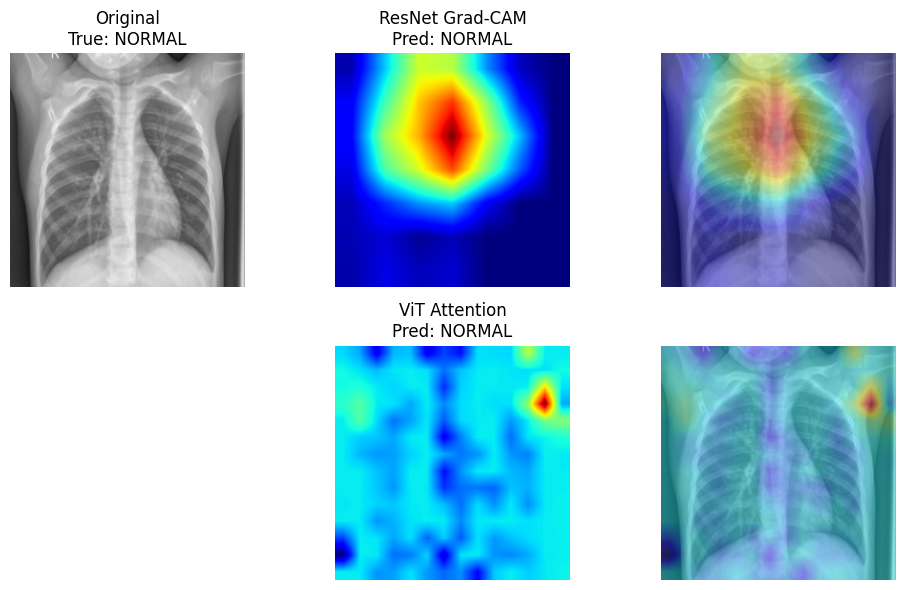


=== Image index 10 ===
True label: NORMAL


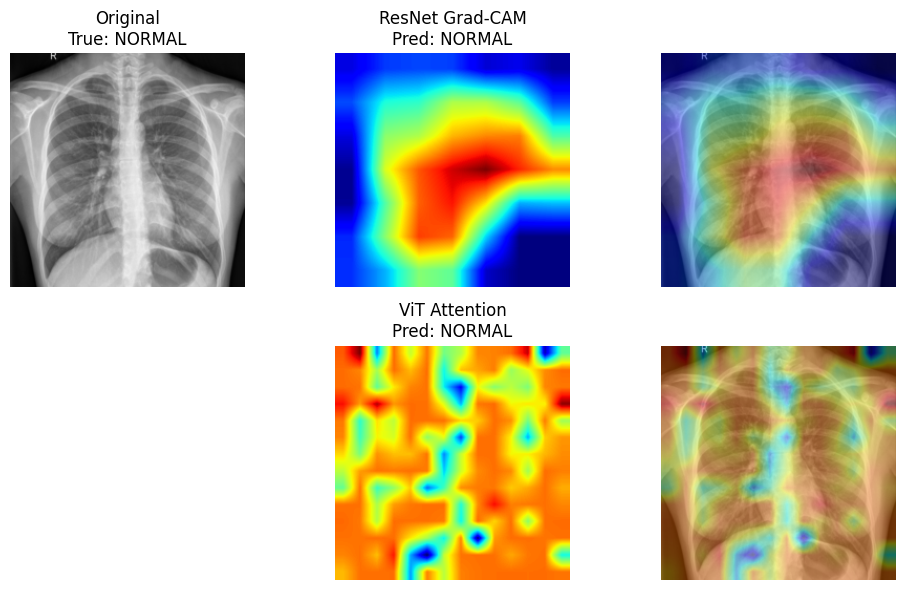


=== Image index 25 ===
True label: NORMAL


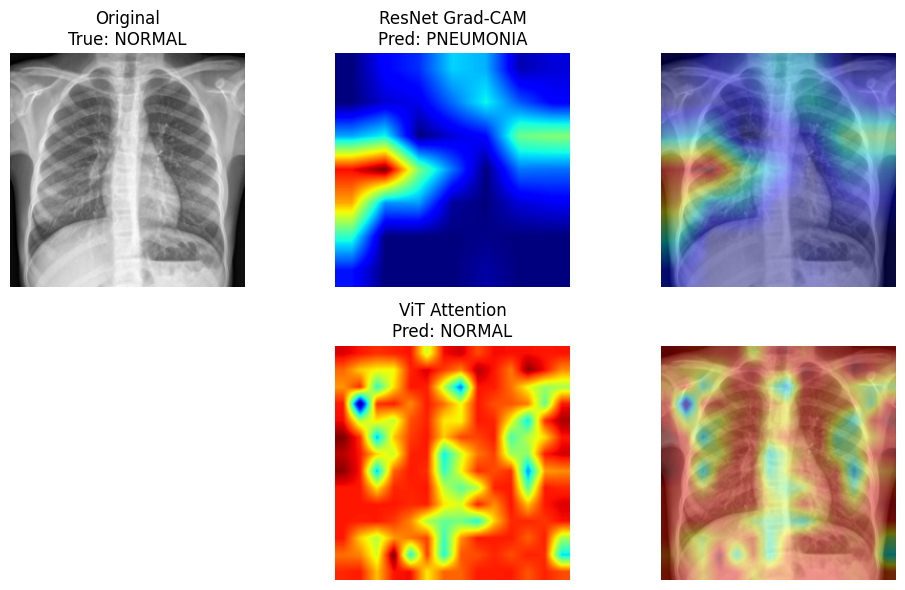

In [ ]:
show_explainability(5)
show_explainability(10)
show_explainability(25)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import torch

def eval_model_for_table(model, weight_path, loader, name):
    """Evaluate model on test set and return metrics in a dict."""
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()

    all_labels, all_preds = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds  = np.array(all_preds)

    acc  = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted", zero_division=0
    )

    return {
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision_weighted": round(prec, 3),
        "Recall_weighted": round(rec, 3),
        "F1_weighted": round(f1, 3),
    }

# evaluate both
resnet_metrics = eval_model_for_table(resnet, "resnet_best.pth", test_loader, "ResNet-50")
vit_metrics    = eval_model_for_table(vit,    "vit_best.pth",    test_loader, "ViT-B/16")

# put into a DataFrame
df_results = pd.DataFrame([resnet_metrics, vit_metrics]).set_index("Model")
print(df_results)

# (optional) save to CSV for report
df_results.to_csv("cnn_vit_comparison.csv")

           Accuracy  Precision_weighted  Recall_weighted  F1_weighted
Model                                                                
ResNet-50     0.800               0.840            0.800        0.779
ViT-B/16      0.814               0.852            0.814        0.797




```
# Fix Class Imbalance
```



In [ ]:
import os
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import numpy as np
import kagglehub

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Re-define path and data_dir (dependencies for datasets) ---
# Download dataset via kagglehub if not already done
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
data_dir = os.path.join(path, "chest_xray")
print("Using data_dir:", data_dir)

# --- Re-define Transforms ---
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# --- Re-define Datasets ---
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"),
                                     transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, "val"),
                                     transform=val_test_transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, "test"),
                                     transform=val_test_transform)

# --- get labels from train_dataset ---
train_labels = [label for _, label in train_dataset]   # 0 = NORMAL, 1 = PNEUMONIA
class_counts = np.bincount(train_labels)               # [count_normal, count_pneumonia]
print("Train class counts:", class_counts)

# --- compute inverse-frequency weights per class ---
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
print("Class weights (inverse freq):", class_weights)

# --- assign a weight to each sample ---
sample_weights = torch.tensor(
    [class_weights[label] for label in train_labels],
    dtype=torch.float
)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),   # one epoch = same length as original train set
    replacement=True
)

batch_size = 32
num_workers = 0 if torch.cuda.is_available() else 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,          # <-- balanced sampling here
    num_workers=num_workers
)

# --- Define val_loader and test_loader (also used in subsequent cells) ---
val_loader   = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=num_workers)

print("Balanced train_loader ready. Batches per epoch:", len(train_loader))
print("Val size:", len(val_dataset), "| Test size:", len(test_dataset))

Using device: cuda
Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Using data_dir: /kaggle/input/chest-xray-pneumonia/chest_xray
Train class counts: [1341 3875]
Class weights (inverse freq): tensor([0.0007, 0.0003])
Balanced train_loader ready. Batches per epoch: 163
Val size: 16 | Test size: 624


In [ ]:
import torch.nn as nn
from torchvision import models
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# ---- build fresh ResNet-50 model ----
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# freeze all layers
for p in resnet.parameters():
    p.requires_grad = False

# unfreeze last conv block
for p in resnet.layer4.parameters():
    p.requires_grad = True

# replace head for 2 classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)
resnet = resnet.to(device)

# loss & optimizer (smaller lr, weight decay for better fine-tuning)
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(
    [
        {"params": resnet.layer4.parameters(), "lr": 5e-6},
        {"params": resnet.fc.parameters(),      "lr": 5e-5},
    ],
    weight_decay=1e-4
)

print("ResNet-50 ready.")


ResNet-50 ready.


In [ ]:
def train_resnet(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0.0
    best_weights = None

    for epoch in range(num_epochs):
        print(f"\n[ResNet] Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # --- TRAIN ---
        model.train()
        running_corrects = 0
        running_total = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()
            running_total += labels.size(0)

        epoch_train_acc = running_corrects / running_total
        train_acc_history.append(epoch_train_acc)

        # --- VALIDATION ---
        model.eval()
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_acc = val_corrects / val_total
        val_acc_history.append(epoch_val_acc)

        print(f"ResNet Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

        # save best weights
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_weights = model.state_dict()

    print(f"\nBest ResNet validation accuracy: {best_val_acc:.4f}")
    if best_weights is not None:
        torch.save(best_weights, "resnet_best.pth")
        print("Best ResNet weights saved to resnet_best.pth")

    # accuracy curves
    plt.figure(figsize=(6,4))
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("ResNet-50 Accuracy (Balanced)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, train_acc_history, val_acc_history



[ResNet] Epoch 1/10
------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ResNet Train Acc: 0.9415 | Val Acc: 0.9375

[ResNet] Epoch 2/10
------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ResNet Train Acc: 0.9586 | Val Acc: 0.8750

[ResNet] Epoch 3/10
------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ResNet Train Acc: 0.9645 | Val Acc: 0.9375

[ResNet] Epoch 4/10
------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ResNet Train Acc: 0.9726 | Val Acc: 1.0000

[ResNet] Epoch 5/10
------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ResNet Train Acc: 0.9707 | Val Acc: 0.9375

[ResNet] Epoch 6/10
------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ResNet Train Acc: 0.9789 | Val Acc: 1.0000

[ResNet] Epoch 7/10
------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ResNet Train Acc: 0.9770 | Val Acc: 1.0000

[ResNet] Epoch 8/10
------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ResNet Train Acc: 0.9854 | Val Acc: 1.0000

[ResNet] Epoch 9/10
------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ResNet Train Acc: 0.9804 | Val Acc: 1.0000

[ResNet] Epoch 10/10
------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ResNet Train Acc: 0.9858 | Val Acc: 1.0000

Best ResNet validation accuracy: 1.0000
Best ResNet weights saved to resnet_best.pth


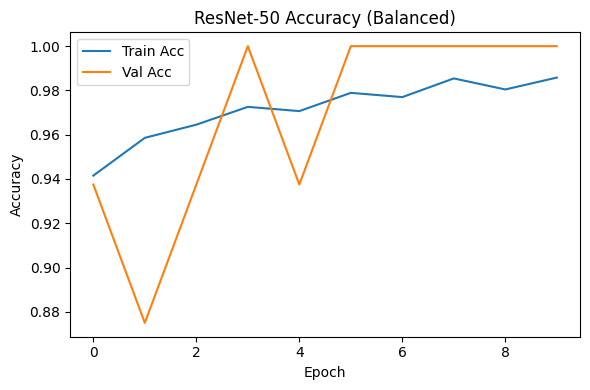

In [ ]:
resnet, resnet_train_acc, resnet_val_acc = train_resnet(
    resnet,
    train_loader,   # balanced
    val_loader,
    criterion_resnet,
    optimizer_resnet,
    num_epochs=10
)

=== ResNet-50 (Balanced) Test Performance ===
              precision    recall  f1-score   support

      NORMAL       0.98      0.61      0.75       234
   PNEUMONIA       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.80      0.82       624
weighted avg       0.87      0.85      0.84       624



<Figure size 400x400 with 0 Axes>

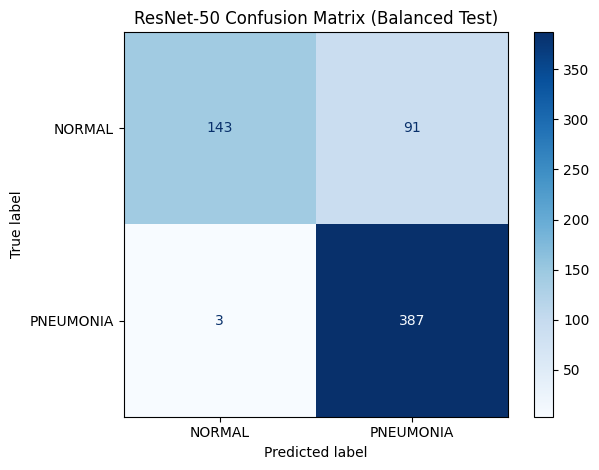

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import torch

# load best weights
resnet.load_state_dict(torch.load("resnet_best.pth", map_location=device))
resnet.eval()

all_labels = []
all_preds  = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)

print("=== ResNet-50 (Balanced) Test Performance ===")
print(classification_report(all_labels, all_preds,
                            target_names=train_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=train_dataset.classes)

plt.figure(figsize=(4,4))
disp.plot(cmap="Blues", values_format="d")
plt.title("ResNet-50 Confusion Matrix (Balanced Test)")
plt.tight_layout()
plt.show()

In [ ]:
from torchvision import models

vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# freeze all
for p in vit.parameters():
    p.requires_grad = False

# unfreeze last encoder block
for p in vit.encoder.layers[-1].parameters():
    p.requires_grad = True

# new 2-class head
num_ftrs_vit = vit.heads.head.in_features
vit.heads.head = nn.Linear(num_ftrs_vit, 2)

vit = vit.to(device)

criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = torch.optim.Adam(
    [
        {"params": vit.encoder.layers[-1].parameters(), "lr": 5e-6},
        {"params": vit.heads.head.parameters(),         "lr": 5e-5},
    ],
    weight_decay=1e-4
)

print("ViT-B/16 ready.")

ViT-B/16 ready.


In [ ]:
def train_vit(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0.0
    best_weights = None

    for epoch in range(num_epochs):
        print(f"\n[ViT] Epoch {epoch+1}/{num_epochs}")
        print("-" * 35)

        # TRAIN
        model.train()
        running_corrects = 0
        running_total = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()
            running_total += labels.size(0)

        epoch_train_acc = running_corrects / running_total
        train_acc_history.append(epoch_train_acc)

        # VALIDATION
        model.eval()
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_acc = val_corrects / val_total
        val_acc_history.append(epoch_val_acc)

        print(f"ViT Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_weights = model.state_dict()

    print(f"\nBest ViT validation accuracy: {best_val_acc:.4f}")
    if best_weights is not None:
        torch.save(best_weights, "vit_best.pth")
        print("Best ViT weights saved to vit_best.pth")

    plt.figure(figsize=(6,4))
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("ViT-B/16 Accuracy (Balanced)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, train_acc_history, val_acc_history


[ViT] Epoch 1/10
-----------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ViT Train Acc: 0.8307 | Val Acc: 0.8750

[ViT] Epoch 2/10
-----------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ViT Train Acc: 0.9285 | Val Acc: 0.9375

[ViT] Epoch 3/10
-----------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ViT Train Acc: 0.9492 | Val Acc: 0.8750

[ViT] Epoch 4/10
-----------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ViT Train Acc: 0.9519 | Val Acc: 0.8750

[ViT] Epoch 5/10
-----------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ViT Train Acc: 0.9618 | Val Acc: 0.8750

[ViT] Epoch 6/10
-----------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ViT Train Acc: 0.9643 | Val Acc: 0.8750

[ViT] Epoch 7/10
-----------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ViT Train Acc: 0.9641 | Val Acc: 0.9375

[ViT] Epoch 8/10
-----------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ViT Train Acc: 0.9730 | Val Acc: 0.9375

[ViT] Epoch 9/10
-----------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ViT Train Acc: 0.9718 | Val Acc: 0.8750

[ViT] Epoch 10/10
-----------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

ViT Train Acc: 0.9732 | Val Acc: 0.8750

Best ViT validation accuracy: 0.9375
Best ViT weights saved to vit_best.pth


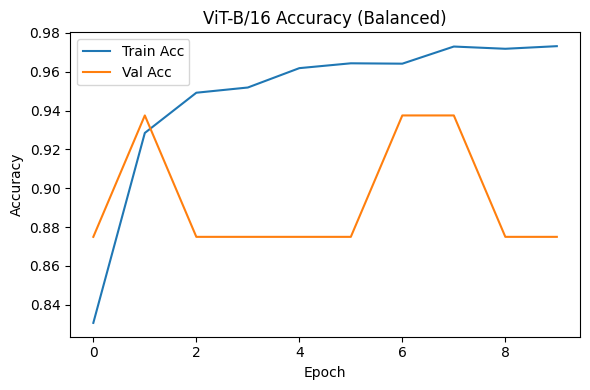

In [ ]:
vit, vit_train_acc, vit_val_acc = train_vit(
    vit,
    train_loader,   # balanced
    val_loader,
    criterion_vit,
    optimizer_vit,
    num_epochs=10   # you can tune this
)

=== ViT-B/16 (Balanced) Test Performance ===
              precision    recall  f1-score   support

      NORMAL       0.95      0.79      0.86       234
   PNEUMONIA       0.89      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.90       624
weighted avg       0.91      0.91      0.90       624



<Figure size 400x400 with 0 Axes>

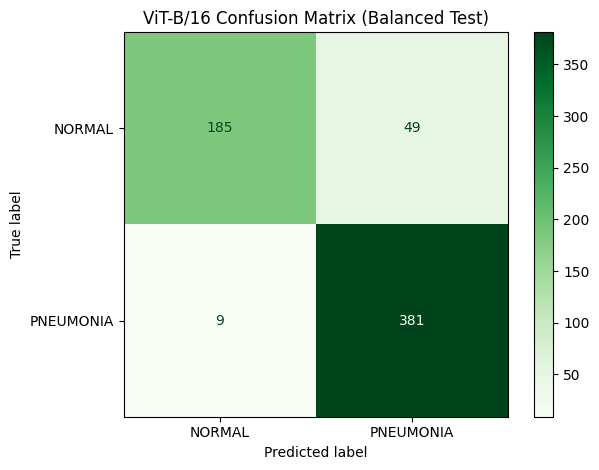

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

vit.load_state_dict(torch.load("vit_best.pth", map_location=device))
vit.eval()

all_labels_vit = []
all_preds_vit  = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = vit(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels_vit.extend(labels.cpu().numpy())
        all_preds_vit.extend(preds.cpu().numpy())

all_labels_vit = np.array(all_labels_vit)
all_preds_vit  = np.array(all_preds_vit)

print("=== ViT-B/16 (Balanced) Test Performance ===")
print(classification_report(all_labels_vit, all_preds_vit,
                            target_names=train_dataset.classes))

cm_vit = confusion_matrix(all_labels_vit, all_preds_vit)
disp_vit = ConfusionMatrixDisplay(confusion_matrix=cm_vit,
                                  display_labels=train_dataset.classes)

plt.figure(figsize=(4,4))
disp_vit.plot(cmap="Greens", values_format="d")
plt.title("ViT-B/16 Confusion Matrix (Balanced Test)")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

def eval_model_for_table(model, weight_path, loader, name):
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()

    all_labels, all_preds = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds  = np.array(all_preds)

    acc  = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted", zero_division=0
    )

    return {
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision_weighted": round(prec, 3),
        "Recall_weighted": round(rec, 3),
        "F1_weighted": round(f1, 3),
    }

resnet_metrics_bal = eval_model_for_table(resnet, "resnet_best.pth", test_loader, "ResNet-50 Balanced")
vit_metrics_bal    = eval_model_for_table(vit,    "vit_best.pth",    test_loader, "ViT-B/16 Balanced")

df_results_bal = pd.DataFrame([resnet_metrics_bal, vit_metrics_bal]).set_index("Model")
print(df_results_bal)
df_results_bal.to_csv("cnn_vit_balanced_comparison.csv")

                    Accuracy  Precision_weighted  Recall_weighted  F1_weighted
Model                                                                         
ResNet-50 Balanced     0.849               0.873            0.849        0.840
ViT-B/16 Balanced      0.907               0.911            0.907        0.905


True label: NORMAL
Predicted label: PNEUMONIA


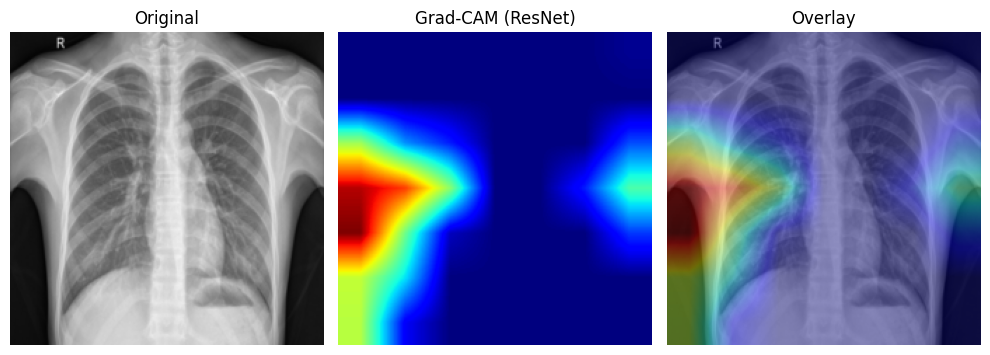

In [ ]:
# ==== Grad-CAM for ResNet-50 (Balanced model) ====
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# load best balanced weights
resnet.load_state_dict(torch.load("resnet_best.pth", map_location=device))
resnet.eval()

feature_maps = None
gradients = None

def forward_hook(module, input, output):
    global feature_maps
    feature_maps = output          # [B, C, H, W]

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]        # [B, C, H, W]

# hook on last conv block in layer4
handle_fwd = resnet.layer4[-1].register_forward_hook(forward_hook)
handle_bwd = resnet.layer4[-1].register_full_backward_hook(backward_hook)

# ---- choose a test image index ----
idx = 12   # change to try different cases
img_tensor, label = test_dataset[idx]
input_batch = img_tensor.unsqueeze(0).to(device)

print("True label:", train_dataset.classes[label])

# forward pass
output = resnet(input_batch)
pred_class = output.argmax(dim=1).item()
print("Predicted label:", train_dataset.classes[pred_class])

# backward for predicted class
resnet.zero_grad()
one_hot = torch.zeros_like(output)
one_hot[0, pred_class] = 1.0
output.backward(gradient=one_hot)

# build CAM
grads = gradients[0]      # [C, H, W]
acts  = feature_maps[0]   # [C, H, W]

weights = grads.mean(dim=(1, 2))   # [C]

cam = torch.zeros(acts.shape[1:], dtype=torch.float32).to(device)  # [H, W]
for w, a in zip(weights, acts):
    cam += w * a

cam = F.relu(cam)
cam = (cam - cam.min()) / (cam.max() + 1e-8)

# upsample CAM to 224x224
cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0),
                    size=(224, 224),
                    mode="bilinear",
                    align_corners=False)
cam = cam.squeeze().detach().cpu().numpy()

# de-normalize original image
img = img_tensor.clone()
img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + \
      torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
img = img.clamp(0, 1).permute(1, 2, 0).cpu().numpy()

# plot
plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(cam, cmap="jet"); plt.title("Grad-CAM (ResNet)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(img); plt.imshow(cam, cmap="jet", alpha=0.4)
plt.title("Overlay"); plt.axis("off")
plt.tight_layout(); plt.show()

# remove hooks
handle_fwd.remove()
handle_bwd.remove()

True label: NORMAL
Predicted label (ViT): NORMAL


sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


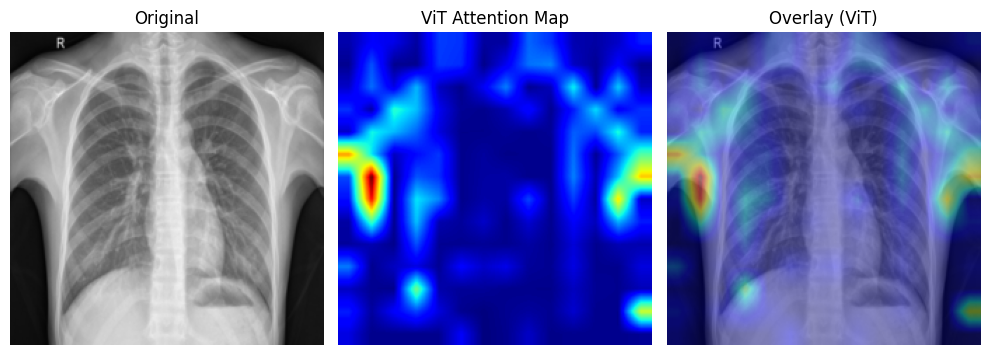

In [ ]:
# ==== ViT-B/16 Attention-style Heatmap (Balanced model) ====
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# load best balanced weights
vit.load_state_dict(torch.load("vit_best.pth", map_location=device))
vit.eval()

vit_tokens = None
vit_grads = None

# hook on last encoder block's ln_1 output (tokens before attention)
def vit_forward_hook(module, input, output):
    global vit_tokens
    vit_tokens = output          # [B, N, D]

def vit_backward_hook(module, grad_in, grad_out):
    global vit_grads
    vit_grads = grad_out[0]      # [B, N, D]

handle_vit_fwd = vit.encoder.layers[-1].ln_1.register_forward_hook(vit_forward_hook)
handle_vit_bwd = vit.encoder.layers[-1].ln_1.register_full_backward_hook(vit_backward_hook)

# ---- use SAME test image index as ResNet for fair comparison ----
idx = 12   # same index as above
img_tensor, label = test_dataset[idx]
input_batch = img_tensor.unsqueeze(0).to(device)

print("True label:", train_dataset.classes[label])

# forward
output = vit(input_batch)
pred_class = output.argmax(dim=1).item()
print("Predicted label (ViT):", train_dataset.classes[pred_class])

# backward for predicted class
vit.zero_grad()
one_hot = torch.zeros_like(output)
one_hot[0, pred_class] = 1.0
output.backward(gradient=one_hot)

# tokens & grads: [1, N, D]
tokens = vit_tokens[0]      # [N, D]
grads  = vit_grads[0]       # [N, D]

# importance per token (average over feature dim)
weights = grads.mean(dim=1)     # [N]

# ignore CLS token at index 0
patch_weights = weights[1:]     # [N-1]

# ViT-B/16 at 224x224 -> 14x14 = 196 patches
num_patches = patch_weights.shape[0]
side = int(num_patches ** 0.5)  # should be 14
vit_cam = patch_weights.reshape(side, side)

# normalize to [0,1]
vit_cam = vit_cam - vit_cam.min()
vit_cam = vit_cam / (vit_cam.max() + 1e-8)

# upsample to 224x224
vit_cam = vit_cam.unsqueeze(0).unsqueeze(0)          # [1,1,H,W]
vit_cam = F.interpolate(vit_cam, size=(224, 224),
                        mode="bilinear", align_corners=False)
vit_cam = vit_cam.squeeze().detach().cpu().numpy()

# de-normalize original image
img = img_tensor.clone()
img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + \
      torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
img = img.clamp(0,1).permute(1,2,0).cpu().numpy()

# plot
plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(vit_cam, cmap="jet"); plt.title("ViT Attention Map"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(img); plt.imshow(vit_cam, cmap="jet", alpha=0.4)
plt.title("Overlay (ViT)"); plt.axis("off")
plt.tight_layout(); plt.show()

handle_vit_fwd.remove()
handle_vit_bwd.remove()


[ViT Fine-tune] Epoch 1/8
----------------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Acc: 0.8970 | Val Acc: 0.8125

[ViT Fine-tune] Epoch 2/8
----------------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Acc: 0.9442 | Val Acc: 0.8125

[ViT Fine-tune] Epoch 3/8
----------------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Acc: 0.9609 | Val Acc: 0.8125

[ViT Fine-tune] Epoch 4/8
----------------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Acc: 0.9634 | Val Acc: 0.9375

[ViT Fine-tune] Epoch 5/8
----------------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Acc: 0.9655 | Val Acc: 0.9375

[ViT Fine-tune] Epoch 6/8
----------------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Acc: 0.9682 | Val Acc: 0.8750

[ViT Fine-tune] Epoch 7/8
----------------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Acc: 0.9664 | Val Acc: 0.8750

[ViT Fine-tune] Epoch 8/8
----------------------------------------


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Acc: 0.9672 | Val Acc: 0.9375

✅ Best validation accuracy: 0.9375
Saved fine-tuned weights as vit_best_finetuned.pth


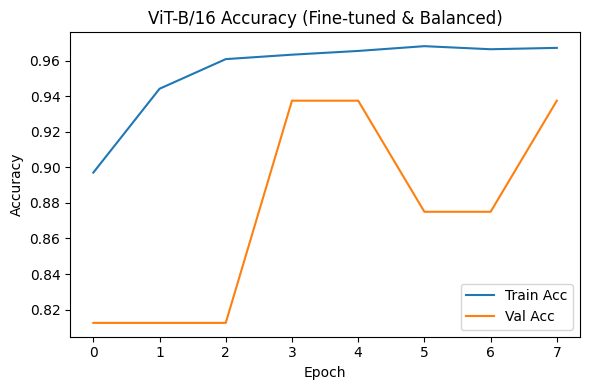

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# ===== Improved Data Augmentation =====
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ===== Rebuild datasets with same paths =====
train_dataset.transform = train_transform
val_dataset.transform   = val_test_transform
test_dataset.transform  = val_test_transform

# ===== Build the ViT model =====
vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# Freeze base layers
for param in vit.parameters():
    param.requires_grad = False

# Unfreeze last encoder layer for fine-tuning
for param in vit.encoder.layers[-1].parameters():
    param.requires_grad = True

# Add dropout for regularization
num_ftrs_vit = vit.heads.head.in_features
vit.heads.head = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(num_ftrs_vit, 2)
)

vit = vit.to(device)

# ===== Training Setup =====
criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = torch.optim.Adam([
    {"params": vit.encoder.layers[-1].parameters(), "lr": 5e-5},
    {"params": vit.heads.head.parameters(),         "lr": 1e-4},
])
num_epochs = 8

# ===== Training Function =====
def train_vit(model, train_loader, val_loader, criterion, optimizer, num_epochs=8):
    train_acc_history, val_acc_history = [], []
    best_val_acc, best_weights = 0.0, None

    for epoch in range(num_epochs):
        print(f"\n[ViT Fine-tune] Epoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        model.train()
        running_corrects, total = 0, 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = running_corrects / total
        train_acc_history.append(train_acc)

        model.eval()
        val_corrects, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_corrects / val_total
        val_acc_history.append(val_acc)

        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = model.state_dict()

    print(f"\n Best validation accuracy: {best_val_acc:.4f}")
    if best_weights:
        torch.save(best_weights, "vit_best_finetuned.pth")
        print("Saved fine-tuned weights as vit_best_finetuned.pth")

    plt.figure(figsize=(6,4))
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("ViT-B/16 Accuracy (Fine-tuned & Balanced)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, train_acc_history, val_acc_history


vit, vit_train_acc, vit_val_acc = train_vit(
    vit, train_loader, val_loader, criterion_vit, optimizer_vit, num_epochs=num_epochs
)


=== ViT-B/16 (Fine-tuned) Test Performance ===
              precision    recall  f1-score   support

      NORMAL       0.96      0.82      0.89       234
   PNEUMONIA       0.90      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



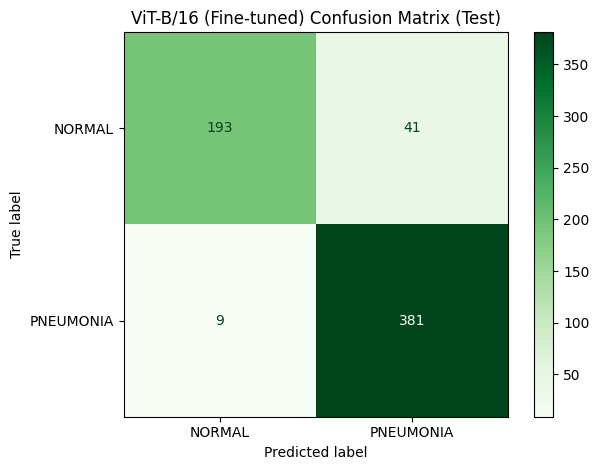

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

vit.load_state_dict(torch.load("vit_best_finetuned.pth", map_location=device))
vit.eval()

all_labels_vit, all_preds_vit = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vit(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels_vit.extend(labels.cpu().numpy())
        all_preds_vit.extend(preds.cpu().numpy())

print("=== ViT-B/16 (Fine-tuned) Test Performance ===")
print(classification_report(all_labels_vit, all_preds_vit, target_names=train_dataset.classes))

cm_vit = confusion_matrix(all_labels_vit, all_preds_vit)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_vit, display_labels=train_dataset.classes)
disp.plot(cmap="Greens", values_format="d")
plt.title("ViT-B/16 (Fine-tuned) Confusion Matrix (Test)")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Overall accuracy (same as in classification_report)
acc = accuracy_score(all_labels_vit, all_preds_vit)

# Weighted precision, recall, F1
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    all_labels_vit, all_preds_vit,
    average="weighted",
    zero_division=0
)

print("=== ViT-B/16 (Fine-tuned) – Weighted Metrics ===")
print(f"Accuracy           : {acc:.4f}")
print(f"Precision (weighted): {prec_w:.4f}")
print(f"Recall (weighted)   : {rec_w:.4f}")
print(f"F1-score (weighted) : {f1_w:.4f}")


=== ViT-B/16 (Fine-tuned) – Weighted Metrics ===
Accuracy           : 0.9199
Precision (weighted): 0.9226
Recall (weighted)   : 0.9199
F1-score (weighted) : 0.9185
